In [7]:
import os
import numpy as np
import skimage
from skimage import io
from skimage import color
from skimage import transform

from random import shuffle

import matplotlib.pyplot as plt 
import io
import pickle
import threading
%matplotlib inline

Цель данной работы - получить базовые навыки обработки изображений и видео.

Входные данные представляют собой набор видео. Каждое видео представлено в виде отдельной директории, хранящей последовательность кадров видео в формате JPEG [NNNN].jpg + файл timestamp.txt, хранящий информацию о временных метках (в мс) каждого кадра. Директория видео имеет следующий формат: [person ID]\_[session ID]\_[phrase ID]\_\*, где [phrase ID] состоит из цифр, произнесенных пользователем.

Для каждого кадра имеется файл [].landmarks, хранящий координаты характеристических точек в соотстветвии с рисунком:
![title](img/figure_68_markup.jpg)


In [25]:
# Функция загрузки временных меток видео
def read_timestamps(timestamps_filename):
    timestamps = []
    if not os.path.isfile(timestamps_filename):
        print("WARNING! can't open timestamps file: " + timestamps_filename)
        return []
    timestamps_lines = [l.strip() for l in open(timestamps_filename).readlines()]
    timestamps_raw = []
    for l in timestamps_lines:
        timestamps_raw = timestamps_raw + l.split(' ')
    if len(timestamps_raw) % 2 != 0:
        print("WARNING! can't parse timestamps file: " + timestamps_filename)
        return []
    for i in range(0, int(len(timestamps_raw)/2)):
        if ':' not in timestamps_raw[i*2]:
            print("WARNING! can't parse timestamps file: " + timestamps_filename + ", ts: " + timestamps_raw[i*2])
            return []
        timestamps.append([timestamps_raw[i*2].split(':')[0], float(timestamps_raw[i*2 + 1])])
    return timestamps

In [26]:
# Функция загрузки разметки характеристических точек лица
def read_landmarks(landmarks_filename):
    if not os.path.isfile(landmarks_filename):
        print("WARNING! can't open timestamps file: " + landmarks_filename)
        return np.array([])
    landmarks = [[float(l.split('\t')[0]), float(l.split('\t')[1])] for l in open(landmarks_filename).readlines()]
    return np.array(landmarks)

<b>Задание 1.</b> Прочитать любую картинку + landmarks из любого видео при помощи skimage и отрисовать при помощи matplotlib

In [21]:
work_dir = "data/"
video_dir =  work_dir + "0_raw_video/"

#------ TODO ---------------

#---------------------------

<b>Задание 2.</b> Провести следующую цепочку преобразований для видео:

- Прочитать изображения в черно-белом формате
- Повернуть изображение так, чтобы глаза находились строго горизонтально
- Вырезать область губ с разрешением 100x60
- Оставить только landmarks с координатами губ и привести их в соответствие с вырезанным изображением


In [22]:
def process_sessions(sessions, results_data_path):
    
    for session in sessions:
        timestamps = read_timestamps(session + "/timestamp.txt")

        image_shape = np.array([100, 60])
        landmarks_num = 68
        landmarks_mouth_num = 20

        data_img = np.zeros([len(timestamps), image_shape[0], image_shape[1]], dtype=np.float32)
        data_lm =  np.zeros([len(timestamps), landmarks_mouth_num, 2], dtype=np.float32)
        data_ts =  np.zeros([len(timestamps)], dtype=np.float32)
        frames = []

        

        session_name = session[session.rfind('/')+1:]
        print ("PROCESS: " + session_name)

        
        dist_eyes_0 = 1
        crop_width_0 = 1
        max_time = 0
        counter = 0
        
        try:
            for frame, time in timestamps:
                if time <= max_time:
                    continue
                max_time = time
                image_filename = session + "/" + frame + ".jpg"
                if not os.path.isfile(image_filename):
                    image_filename = session + "/" + frame + ".jpeg"
                if not os.path.isfile(image_filename):
                    continue

                lm = read_landmarks(image_filename + ".landmarks")
                if (lm.shape[0] != landmarks_num):
                    continue
                
                # ------ TODO ---------------------------
                # 1. Прочитать изображение
                # 2. Повернуть
                # 3. Вырезать изображение рта         
                # 4. Оставить 20 landmarks изображения рта
                # 5. Сохранить в соответствующие массивы:
                #    data_img[counter,:,:] = 
                #    data_lm[counter,:,:] = (lm[48:68,:] - crop_bound[0]) * scale_factor
                #    data_ts[counter] = time
                # ---------------------------------------
                image_gray = skimage.io.imread(image_filename, as_grey=True)
                #print(image_gray.dtype)

                crop_coeff = 100./60.

                mean_image = np.array([image_gray.shape[1]/2, image_gray.shape[0]/2])

                #calculate rotation angel
                mean_left_eye = np.mean(lm[36:42,:], axis=0)
                mean_right_eye = np.mean(lm[42:48,:], axis=0)
                dist_eye = np.sqrt(np.sum((mean_right_eye - mean_left_eye) ** 2))
                dist_mouth = np.sqrt(np.sum((lm[48,:] - lm[54,:]) ** 2))

                if (counter == 0):
                    dist_eyes_0 = dist_eye
                    crop_width_0 = dist_mouth * crop_coeff

                crop_width = crop_width_0 * (dist_eye / dist_eyes_0)
                crop_height = crop_width * (image_shape[1] / image_shape[0])


                # rotate
                rotate_angel_rad = -np.arccos((mean_right_eye - mean_left_eye)[0]/dist_eye)
                rotate_angel = 180 * (rotate_angel_rad / np.pi)
                rotate_matrix = np.array([[np.cos(rotate_angel_rad), -np.sin(rotate_angel_rad)],
                                          [np.sin(rotate_angel_rad), np.cos(rotate_angel_rad)]])
                lm = np.matmul(lm - mean_image, rotate_matrix) + mean_image
                image_gray = skimage.transform.rotate(image_gray, rotate_angel)

                lm_mouth_mean = np.mean(lm[48:68,:], axis=0)

                # crop
                crop_bound =np.array([[ int(lm_mouth_mean[0] - crop_width * 0.5), int(lm_mouth_mean[1] - crop_height * 0.5) ],
                                      [ int(lm_mouth_mean[0] + crop_width * 0.5), int(lm_mouth_mean[1] + crop_height * 0.5) ]])

                
                data_img[counter,:,:] = skimage.transform.resize(image_gray[crop_bound[0][1]:crop_bound[1][1], crop_bound[0][0]:crop_bound[1][0]], [image_shape[1],image_shape[0]], mode='constant').transpose()
                scale_factor = np.array([image_shape[0]/float(crop_bound[1][0] - crop_bound[0][0]), image_shape[1]/float(crop_bound[1][1] - crop_bound[0][1])])
                data_lm[counter,:,:] = (lm[48:68,:] - crop_bound[0]) * scale_factor
                data_ts[counter] = time

                #lm_indices = data_lm[counter,:,:].astype(dtype=np.int32)
                #for indx in lm_indices:
                #    data_img[counter, indx[0]-1:indx[0]+1, indx[1]-1:indx[1]+1] = 0
                #plt.imshow(image_gray[crop_bound[0][1]:crop_bound[1][1], crop_bound[0][0]:crop_bound[1][0]], cmap='gray')
                #plt.imshow(data_img[counter,:,:].transpose(), cmap='gray')
                
                
                frames.append(frame)
                counter = counter + 1
               
            data_img = np.resize(data_img, [counter, image_shape[0], image_shape[1]])
            data_lm =  np.resize(data_lm,  [counter, landmarks_mouth_num, 2])
            data_ts =  np.resize(data_ts,  [counter, 1])
            
            # сохраняем данные в бинарный файл при помощи библиотеки pickle
            with open(results_data_path + session_name + ".pickle", "wb") as f:
                pickle.dump(data_img, f)
                pickle.dump(data_lm, f)
                pickle.dump(data_ts, f)
                pickle.dump(frames, f)
        except:
            print ("ERROR! can't process session: " + session_name)

Обработаем все видео

In [27]:
results_data_path = work_dir + "1_video_lips/"
#os.system("mkdir " + results_data_path)
sessions = [(video_dir + d) for d in os.listdir(video_dir)]

process_sessions(sessions, results_data_path)


PROCESS: F0014_02_17538_Android_htc (id: 277904)
PROCESS: F0224_02_73981_Android_SM (id: 277904)
PROCESS: F0248_01_08493_iPhone_6S (id: 277904)
PROCESS: F0308_02_5329084671_Android_SM (id: 277904)
PROCESS: F037_02_42365_iPhone_iphone6 (id: 277904)
PROCESS: M0284_01_17263_Android_SM (id: 277904)
PROCESS: M0562_01_1209674835_iPhone_6S (id: 277904)
PROCESS: M0567_01_2793086514_Android_SM (id: 277904)
PROCESS: M0602_01_40792_iPhone_6S (id: 277904)


Проветим корректность полученных данных

float32
(124, 1)
[ 1840.]
0055


C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


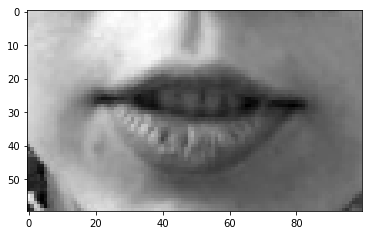

In [29]:
with open(results_data_path + "F0248_01_08493_iPhone_6S.pickle", "rb") as f:
    data_img_test = pickle.load(f)
    data_lm_test = pickle.load(f)
    data_ts_test = pickle.load(f)
    frames_test = pickle.load(f)

index = 55
plt.imshow(data_img_test[index,:,:].transpose(), cmap='gray')
print(data_img_test.dtype)
print(data_ts_test.shape)
print(data_ts_test[index])
print(frames_test[index])
debug_path = work_dir + "debug/"

lm_indices = data_lm_test.astype(dtype=np.int32)
for i in range(0, len(frames_test)):
    for indx in lm_indices[i,:,:]:
        data_img_test[i, indx[0]-2:indx[0]+2, indx[1]-2:indx[1]+1] = 0
    skimage.io.imsave(debug_path + frames_test[i] + ".png", data_img_test[i,:,:].transpose())